## Part 2: Network construction, editing and visualization

### 2.1 Network construction

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual,  HBox, VBox
from IPython.display import display, HTML

from utils.ui_functions import alert_user, StopExecution, make_download_button
from utils.conf import my_style, my_layout

First, we need to load the data prepared in notebook 1.

In [2]:
sfw_matrix = pd.read_pickle('results/sfw_matrix.pickle')
trophic_levels = pd.read_pickle('results/trophic_levels.pickle')

We have the option to name our network after the below cell is run.

In [3]:
G = nx.from_pandas_adjacency(sfw_matrix, create_using=nx.DiGraph)
G.name = 'My network'
# remove default edge weights
for n1, n2, d in G.edges(data=True):
    d.clear()
    
graph_name_input = widgets.Text(placeholder='The name of this network', value=G.name, description='Name:', disabled=False, style=my_style)
rename_button = widgets.Button(description='Rename', disabled=False, button_style='primary',icon='edit')
rename_log = widgets.Output(layout={'border': '1px solid blue'})
display(rename_log)
def rename_graph(widget_name):
    G.name = graph_name_input.value
    rename_log.clear_output()
    rename_log.append_display_data(f'Graph renamed to "{G.name}"')
rename_button.on_click(rename_graph)

# TODO make sure the network has a name
HBox([graph_name_input, rename_button])

Output(layout=Layout(border='1px solid blue'))

The below cell provides some basic information about the network.

In [4]:
if not G.name:
    alert_user('The network does not have a name!\nPlease use the "Rename" button in the above cell.')
    raise StopExecution

print('--- Basic network info ---')
print(f'Name: {G.name}')
typ = 'directed' if nx.is_directed(G) else 'undirected'
print(f'Type: {typ}')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')
sc = 'yes' if nx.is_strongly_connected(G) else 'no'
print(f'Strongly connected: {sc}')
print(f'Density: {nx.density(G):.5f}')

--- Basic network info ---
Name: My network
Type: directed
Nodes: 24
Edges: 94
Strongly connected: no
Density: 0.17029


### 2.2 Network editing

With this cell a GUI is loaded that allows to remove nodes from the network if needed.

In [5]:
select_node_dropdown = widgets.Dropdown(options=sorted(list(G.nodes)), description='Selected node:', disabled=False, 
                                        layout=my_layout, style=my_style)
delete_button = widgets.Button(description='Delete this node', disabled=False, button_style='danger',icon='trash')
delete_log = widgets.Output(layout={'border': '1px solid blue'})
def button_action(widget_name):
    selected_node = select_node_dropdown.value
    if selected_node:
        G.remove_node(selected_node)
        select_node_dropdown.options = sorted(list(G.nodes))
        delete_log.append_display_data(f'Node "{selected_node}" was removed')
delete_button.on_click(button_action)
display(delete_log)
HBox([select_node_dropdown, delete_button])

Output(layout=Layout(border='1px solid blue'))

### 2.3 Network visualization

#### Static visualization of general graphs

Analysis of networks often begins with a visual inspection. Therefore, a function is provided which draws the input network using the Kamada-Kawai layout algorithm.

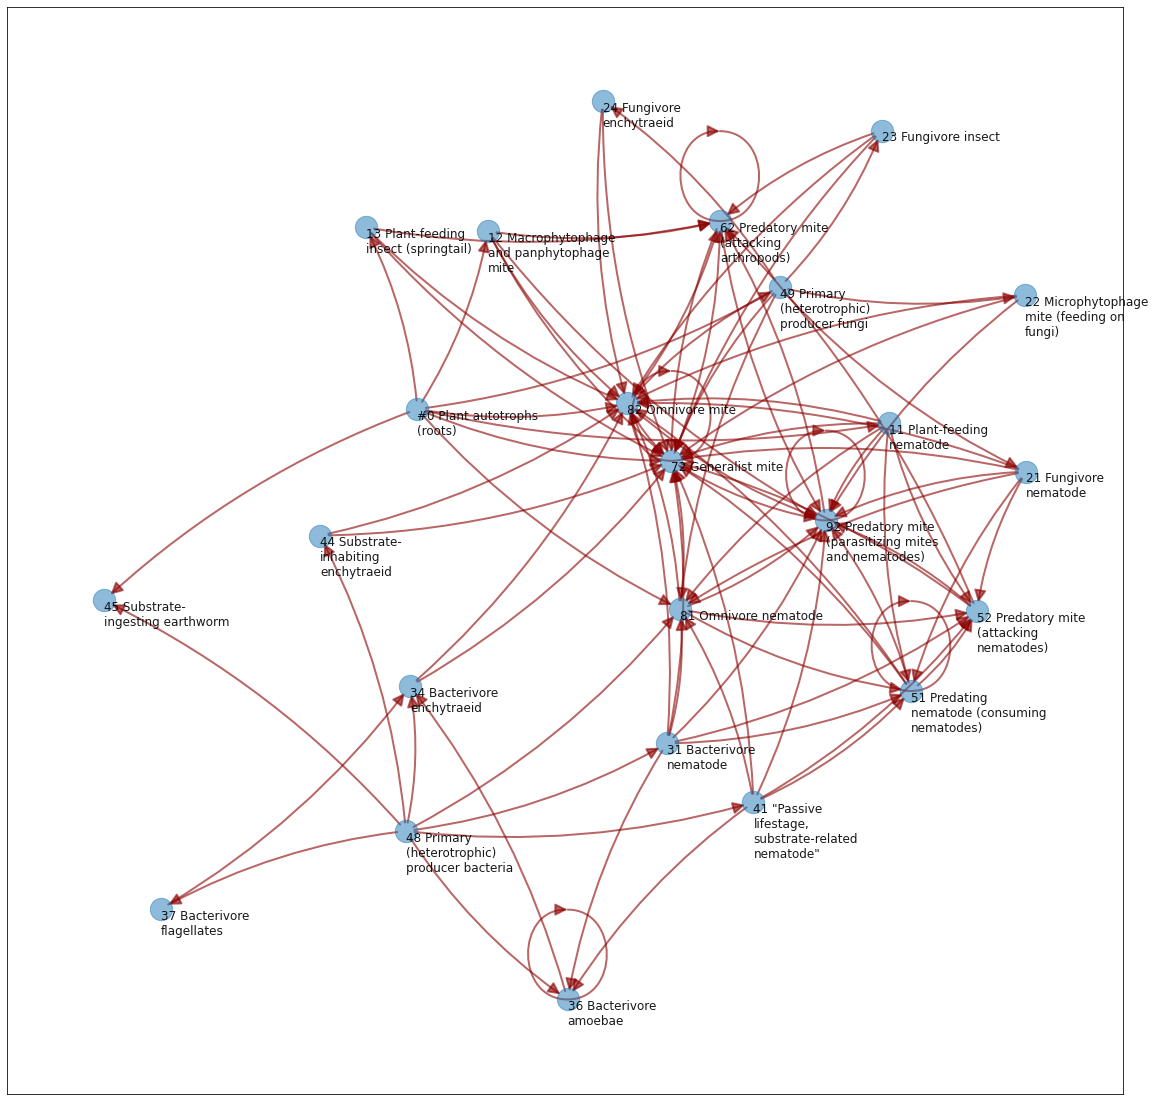

In [7]:
from utils.functions import draw_network

fig, ax = plt.subplots(figsize=(20, 20))
draw_network(G, ax)

### Interactive visualization of layered (hierarchical) networks

Here a specialized interactive visualization of hierarchical networks is provided which is especially important when visulising food webs. After the cell is run a GUI offers three ways of viewing the network and some formating. Note that "Draw inline" and "Open in new tab" offer interactive visualisation.  

In [10]:
import textwrap
import webbrowser
from pyvis.network import Network
from utils import conf
from utils import functions
from utils.ui_functions import make_network_download_button
import copy

trophic_levels_dict = trophic_levels.to_dict()

out = widgets.Output(layout={'border': '0px'})
@out.capture()
def draw_network_inline(widget_name):
    out.clear_output()
    vis_G = prepare_visualization()
    GG = copy.copy(vis_G)
    GG.conf = False
    GG.set_options(conf.hierarchical_food_web_visual_settings_inline)
    display(HTML(GG.generate_html()))

def draw_network_new_tab():
    vis_G = prepare_visualization()
    GG = copy.copy(vis_G)
    GG.conf = True
    GG.set_options(conf.hierarchical_food_web_visual_settings_standalone)
    web_page = f'results/{G.name}.html'
    GG.write_html(web_page)
    #webbrowser.open(web_page, new=1, autoraise=True)
    #webbrowser.open_new(web_page)
    display(HTML(f"""<a target="_blank" href="{web_page}"><button type="button" style="background-color:green;color:white;margin-left:3px;width:140px;height:30px;border-width:0px;">Open in new tab</button></a>"""))

    

color_select = widgets.Dropdown(options=['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'bone', 'pink',
                                         'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 
                                         'gist_heat', 'copper'],
                                value='spring',           
                                description='Colormap:',
                                disabled=False)
shape_select = widgets.Dropdown(options=['ellipse', 'circle', 'database', 'box', 'text', 'diamond', 'dot', 'star', 
                                         'triangle', 'triangleDown', 'hexagon', 'square'],
                                value='box',           
                                description='Node shape:',
                                disabled=False)
label_width_slider  = widgets.IntSlider(value=20, min=6, max=40, step=2, description='Label width:', disabled=False,
                                        continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
draw_inline_button = widgets.Button(description='Draw inline', disabled=False, button_style='primary')
# draw_outside_button = widgets.Button(description='Open in new tab', disabled=False, button_style='primary')
# draw_outside_button.style.button_color = 'green'
draw_inline_button.on_click(draw_network_inline)
# draw_outside_button.on_click(draw_network_new_tab)

def prepare_visualization():
    colors = functions.get_colors(len(set(trophic_levels)), colormap=color_select.value)
    vis_G = Network('800px', '1200px', notebook=False)
    # add nodes
    for node in G.nodes():
        vis_G.add_node(node, 
                       label='\n'.join(textwrap.wrap(node, label_width_slider.value, break_long_words=True)), 
                       level=max(trophic_levels) - trophic_levels_dict.get(node,-1), 
                       shape=shape_select.value,
                       color=colors[trophic_levels_dict[node]] if node in trophic_levels_dict else '#FFFFFF')
    # and edges
    for source, target in list(G.edges()):
        vis_G.add_edge(source, target)
    return vis_G  

delete_log = widgets.Output(layout={'border': '1px solid blue'})
display(delete_log)


display(VBox([color_select, shape_select, label_width_slider, draw_inline_button]))  #, draw_outside_button]))
draw_network_new_tab()
display(HTML(make_network_download_button(G.name)))
display(out)

Output(layout=Layout(border='1px solid blue'))

Output(layout=Layout(border='0px'))

In [9]:
nx.write_gpickle(G, 'results/G.pickle')